# Artificial Lunar Landscape Images Segmentation using UNet-VGG16 CNN Architecture
## Background and Motivation
It is often difficult to conduct any kind of machine learning experiment on lunar images because of their scarcity and lack of annotation. The goal of this dataset is to provide everyone with a sample of artificial yet realistic lunar landscapes, which can be used to train rock detection algorithms. Those trained algorithms can then be tested on actual lunar pictures. The dataset currently contains 9,766 realistic renders of rocky lunar landscapes, and their segmented equivalents (the 3 classes are the sky, smaller rocks, and larger rocks). A table of bounding boxes for all larger rocks and processed, cleaned-up ground truth images are also provided. 
## Technical Information
* Render dimensions: 720x480 pixels
* Camera FOV: 65°
* Camera film aperture: 36x24mm
* Camera focal length: ~20mm
* Camera orientation: Yaw between 0° and 360°; Pitch between -30° and 0° (so as to limit the portion of images occupied by the sky); Roll between -20° and 20°
* Sun elevation: Random, uniform distribution between 20° and 40° for 75% of frames, between 40° and 50° for 25% of frames
* Sun heading: Random, uniform distribution between 0° and 360°

## Acknowledgements
* This dataset was created by Romain Pessia and Genya Ishigami of the [Space Robotics Group](http://www.srg.mech.keio.ac.jp/index_en.html), Keio University, Japan. The authors also thank Quentin Jodelet, Keio University, for his invaluable help. To contact the author of the dataset, please reach out to [pessia[at]keio.jp]("mailto:pessia@keio.jp")
* The software used for creating the images and their ground truth is [Planetside Software's Terragen](https://planetside.co.uk/).
* The authors used NASA's [LRO LOLA Elevation Model](https://astrogeology.usgs.gov/search/details/Moon/LRO/LOLA/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014/cub) as a source of large-scale terrain data.

# Installing and Importing Libraries

In [1]:
import os
import numpy as np
from numpy import expand_dims
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, LeakyReLU, ReLU, concatenate, Dropout, BatchNormalization, Activation, Reshape

# Dataset

In [3]:
data_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/'
render_data_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/render/'
ground_data_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/ground/'
clean_data_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/'
real_moon_images_dir= '../input/artificial-lunar-rocky-landscape-dataset/real_moon_images/'
# img_width, img_height = 512, 512 
img_width, img_height = 500, 500 
channels = 3

In [4]:
images = sorted(os.listdir(data_dir+'render/'))
print('Total number of images:', len(images))

Total number of images: 9766


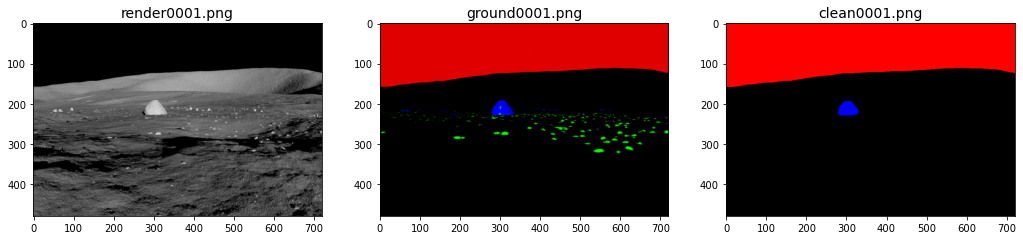

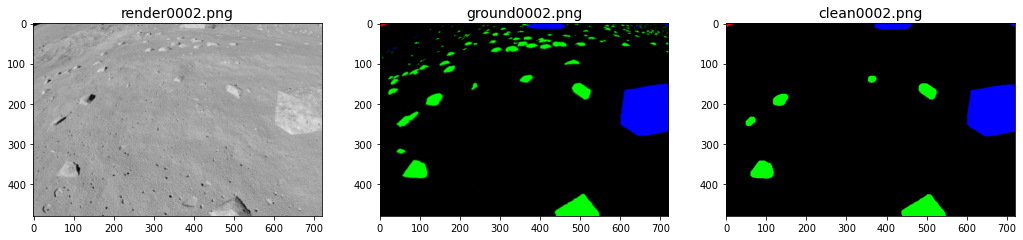

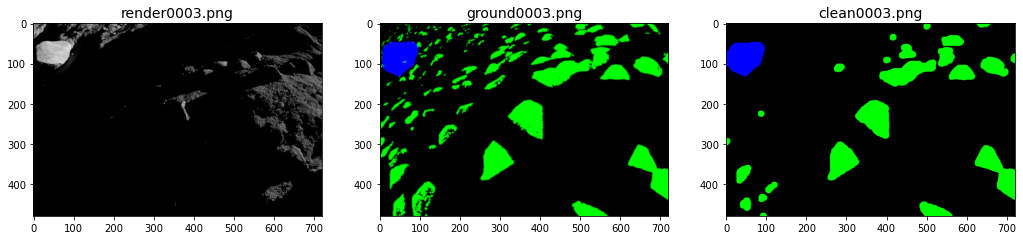

In [5]:
file_names= ['0001.png', '0002.png', '0003.png']

for file in file_names:
    plt.figure(figsize=(30,30))
    plt.subplot(5,5,1).set_title('render'+file, fontsize=14)
    img = cv.imread(render_data_dir+'render'+file)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.subplot(5,5,1+1).set_title('ground'+file, fontsize=14)
    img = cv.imread(ground_data_dir+'ground'+file)  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.subplot(5,5,1+2).set_title('clean'+file, fontsize=14)
    img = cv.imread(clean_data_dir+'clean'+file)  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.savefig('image'+file, transparent= False, bbox_inches= 'tight', dpi= 400)

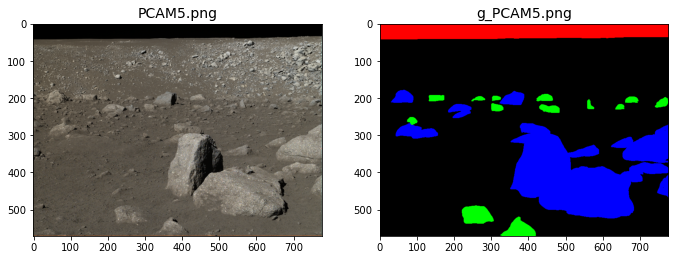

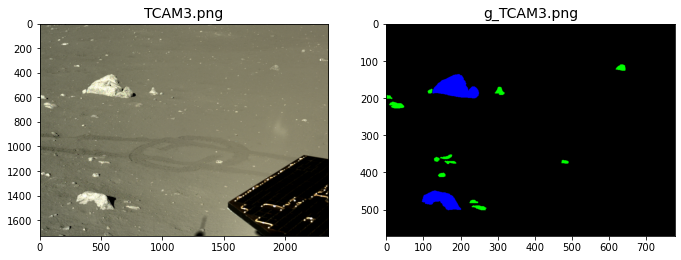

In [6]:
file_names= ['PCAM5.png', 'TCAM3.png']

for file in file_names:
    plt.figure(figsize=(30,30))
    plt.subplot(5,5,1).set_title(file, fontsize=14)
    img = cv.imread(real_moon_images_dir+file)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
#     plt.axis('off') 
    plt.subplot(5,5,1+1).set_title('g_'+file, fontsize=14)
    img = cv.imread(real_moon_images_dir+'g_'+file)  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.savefig('image_'+file, transparent= False, bbox_inches= 'tight', dpi= 400)

# Data Generator

In [7]:
def ExtractData_X(data_dir):
    RenderImg = sorted(os.listdir(data_dir+'render'))
    X=[]
    count = 0
    
    for i in range(len(RenderImg)):
        if count < 5600:
            count = count+1
            img_x = cv.imread(data_dir + 'render/'+RenderImg[i])
            img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
            img_x = cv.resize(img_x,(500,500))
            X.append(img_x)

    X = np.array(X)

    return X

def ExtractData_Y(data_dir):
    GroundImg = sorted(os.listdir(data_dir+'ground'))
    Y=[]
    count = 0
    
    for i in range(len(GroundImg)):
        if count < 5600:
            count = count+1
            img_y = cv.imread(data_dir + 'ground/'+GroundImg[i])
            img_y = cv.cvtColor(img_y, cv.COLOR_BGR2RGB)
            img_y = cv.resize(img_y,(500,500))
            Y.append(img_y)
            
    Y = np.array(Y)
    
    return Y

In [8]:
X = ExtractData_X(data_dir)
Y = ExtractData_Y(data_dir)

In [9]:
print(X.shape)
print(Y.shape)

(5600, 500, 500, 3)
(5600, 500, 500, 3)


In [10]:
def TrainImageGenerator(X,Y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        Y_input = Y[i].reshape(1,500,500,3)
        yield (X_input,Y_input)

# Model

In [11]:
def custom_vgg16_model(input_shape= (512, 512, 3)):
    
    vgg16 = VGG16(include_top= False, input_shape= input_shape, weights= 'imagenet')
    
    trainable_layers = [
         'block1_conv1',
         'block1_conv2',
         'block2_conv1',
         'block2_conv2',
         'block3_conv1',
         'block3_conv2',
         'block3_conv3',
         'block4_conv1',
         'block4_conv2',
         'block4_conv3',
         'block5_conv1',
         'block5_conv2',
         'block5_conv3'
    ]
    
    for layer in vgg16.layers:
        if layer.name in trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False
    
    return vgg16

In [12]:
vgg16 = custom_vgg16_model((img_width, img_height, channels))
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
______________________________________________________________

In [35]:
def custom_UNet(base_model):
    model = Conv2DTranspose(256,(3,3),strides=(2, 2))(base_model.output)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model)    

    concat_1 = concatenate([model,base_model.get_layer("block5_conv3").output])

    model = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model)

    model = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model) 

    concat_2 = concatenate([model,base_model.get_layer("block4_conv3").output])

    model = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model)

    model = Conv2DTranspose(512,(3,3),strides=(2, 2))(model)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model) 

    concat_3 = concatenate([model,base_model.get_layer("block3_conv3").output])

    model = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model)

    model = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model)
    model = LeakyReLU(0.1)(model)
    model = BatchNormalization()(model) 

    concat_4 = concatenate([model,base_model.get_layer("block2_conv2").output])

    model = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model = LeakyReLU(0.1)(model)
#     model = Dropout(0.1)(model)
    model = BatchNormalization()(model)

    model = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model)
    model = LeakyReLU(0.1)(model)
#     model = Dropout(0.01)(model) #dropout
    model = BatchNormalization()(model) 

    concat_5 = concatenate([model,base_model.get_layer("block1_conv2").output])

    model = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model = LeakyReLU(0.1)(model)
    model = Dropout(0.12)(model) #dropout
    model = BatchNormalization()(model)
    
    model = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model)
    model = LeakyReLU(0.1)(model)
    model = Dropout(0.47)(model) #dropout
    model = BatchNormalization()(model)

    model = Model(base_model.input,model)
    
    return model

In [36]:
model = custom_UNet(vgg16)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

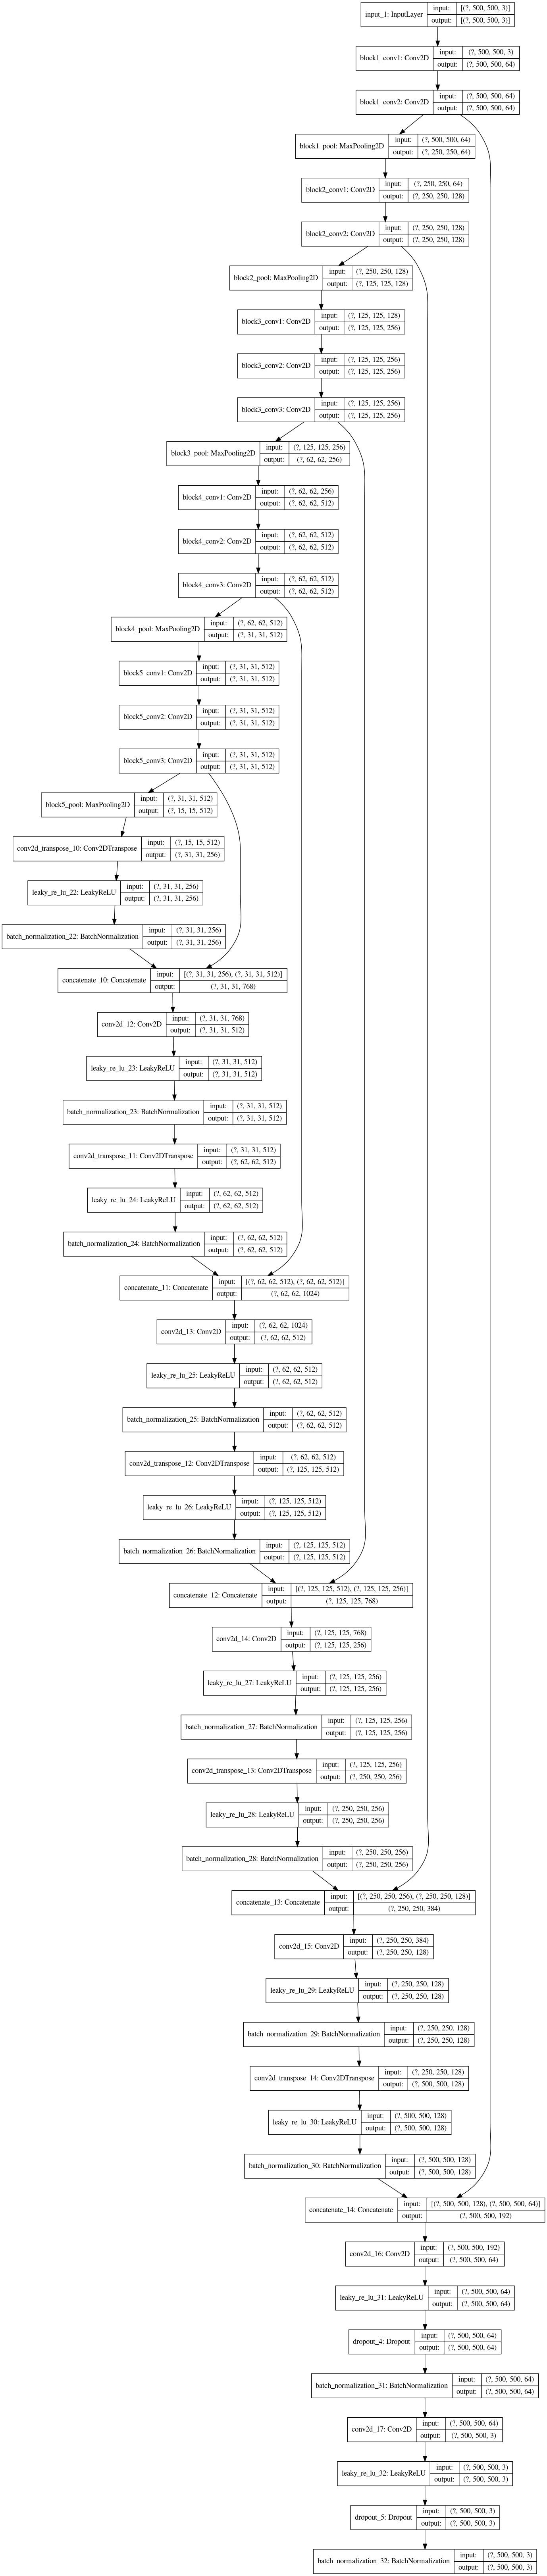

In [37]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Training

In [38]:
model.compile(optimizer= keras.optimizers.Adam(lr= 1e-4), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [39]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    verbose=1,
    mode='auto', 
    monitor='loss',
    save_best_only=True
)

In [40]:
history = model.fit(
    TrainImageGenerator(X, Y),
    epochs = 30,
    steps_per_epoch = 100,
    verbose = 1,
    callbacks = [checkpoint],
    shuffle = True
)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 144.5811 - accuracy: 0.3732
Epoch 00001: loss improved from inf to 144.58105, saving model to model.h5
100/100 [==============================] - 19s 192ms/step - loss: 144.5811 - accuracy: 0.3732
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 42.2072 - accuracy: 0.3845
Epoch 00002: loss improved from 144.58105 to 42.20715, saving model to model.h5
100/100 [==============================] - 19s 193ms/step - loss: 42.2072 - accuracy: 0.3845
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 33.0369 - accuracy: 0.4003
Epoch 00003: loss improved from 42.20715 to 33.03690, saving model to model.h5
100/100 [==============================] - 19s 192ms/step - loss: 33.0369 - accuracy: 0.4003
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 32.2465 - accuracy: 0.4265
Epoch 00004: loss improved from 33.03690 to 32.24655, saving model to model.h5
100/100 [=========

In [41]:
model = load_model('./model.h5')

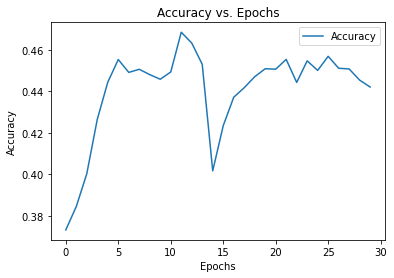

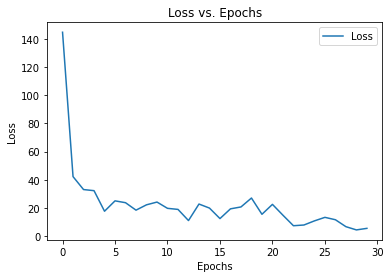

In [42]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Accuracy vs. Epochs')
plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Accuracy'])
plt.savefig('acc_vs_epochs_plot.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Loss vs. Epochs')
# plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss'])
plt.savefig('loss_vs_epochs_plot.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

# Prediction

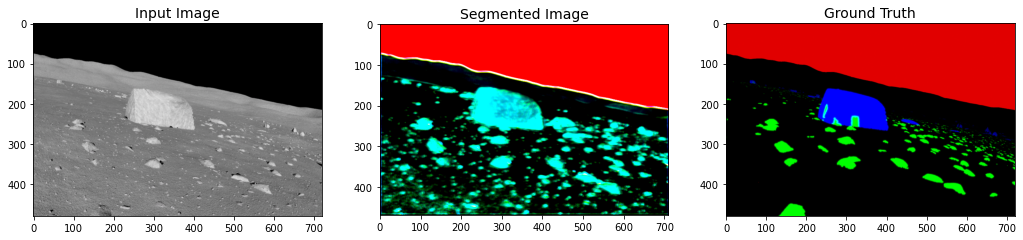

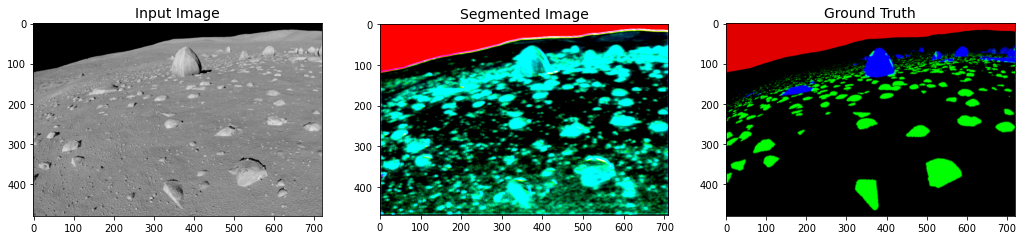

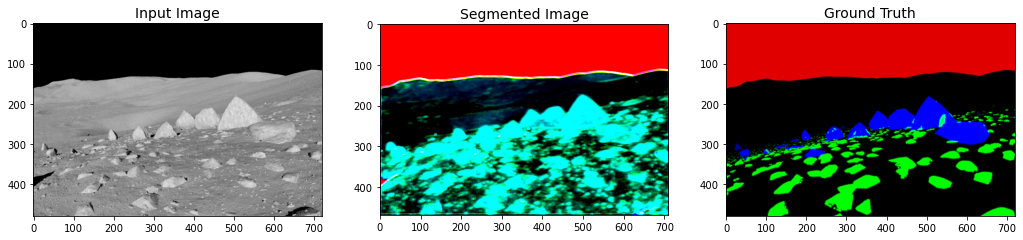

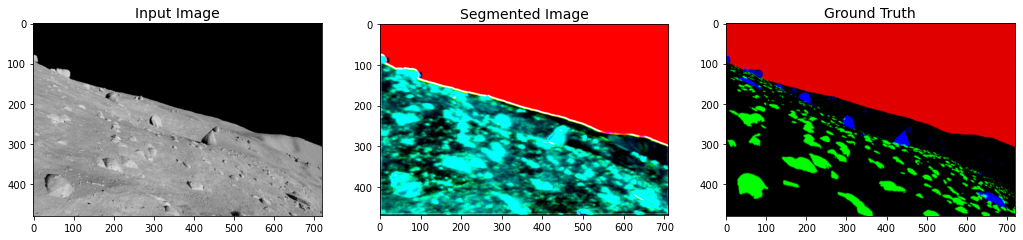

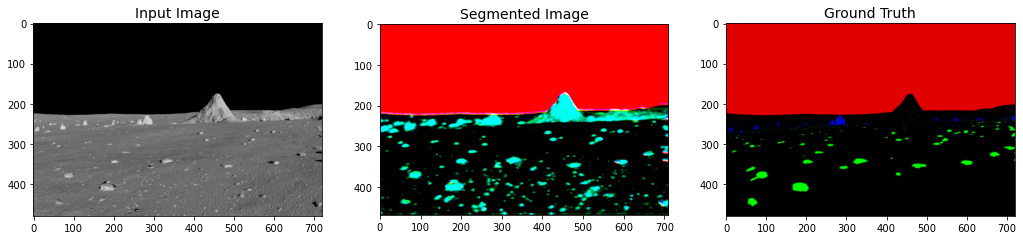

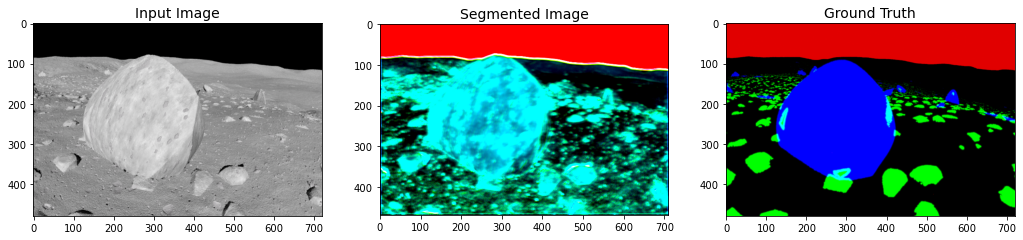

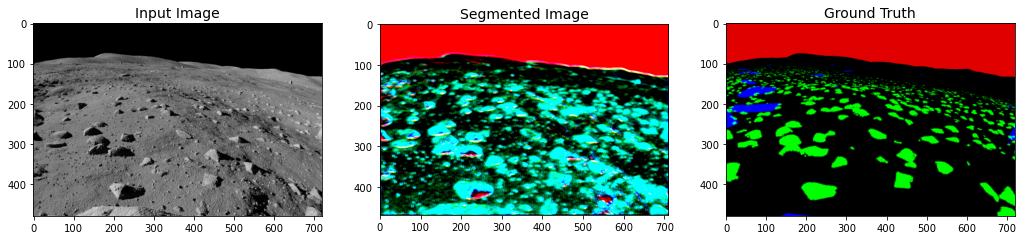

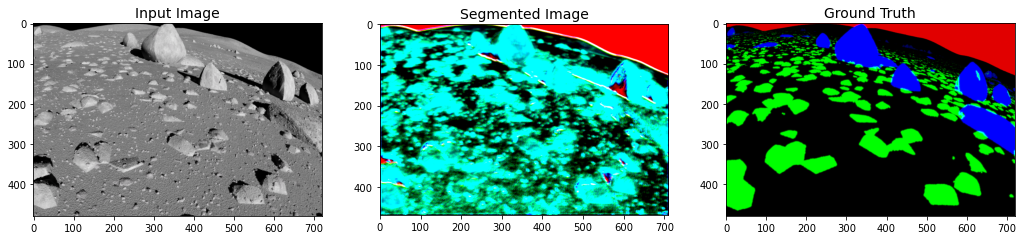

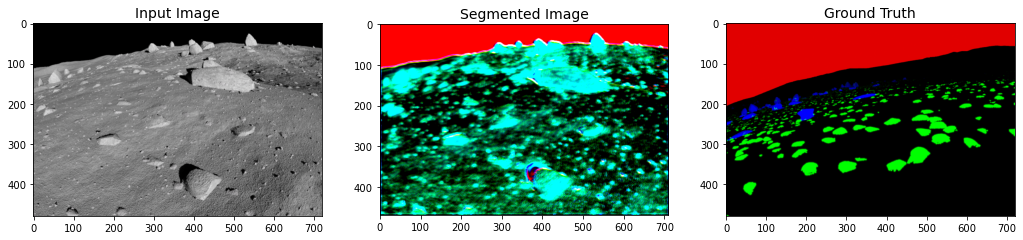

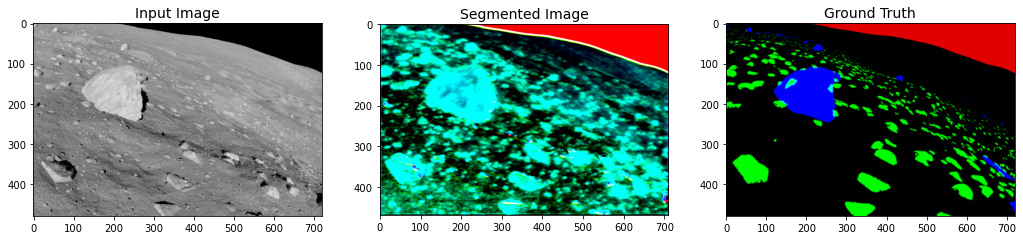

In [46]:
# file_names= ['0001.png', '1985.png', '2256.png', '4569.png', '4521.png', '1502.png', '0256.png', '4200.png', '2299.png', '2255.png']
file_names= ['0016.png', '1985.png', '2256.png', '4445.png', '3573.png', '0526.png', '4200.png', '5757.png', '1936.png', '3883.png']
# file_names= ['0001.png', '1985.png', '2256.png']

for file in file_names:
    plt.figure(figsize=(30,30))
    plt.subplot(5,5,1)
    img = cv.imread(render_data_dir+'render'+file)  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.title("Input Image",fontsize=14)
    plt.imshow(img)
    img = cv.resize(img,(500,500))
    img = img.reshape(1,500,500,3)
    pred = model.predict(img)
    pred = pred.reshape(500,500,3)
    pred = cv.resize(pred,(710,470))
    plt.subplot(5,5,1+1)
    plt.title("Segmented Image",fontsize=14)
    plt.imshow(pred)
    plt.subplot(5,5,1+2)
    img = cv.imread(ground_data_dir+'ground'+file)  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.title("Ground Truth",fontsize=14)
    plt.imshow(img)
    plt.savefig('pred'+file, transparent= False, bbox_inches= 'tight', dpi= 400)